In [12]:
import numpy as np
from pathlib import Path
from PIL import Image
import json
import random
import pandas as pd

In [13]:
camera_parameters = Path("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/LPFF/camera_parameters.json")
with open(camera_parameters, "r") as f:
    camera_parameters=json.load(f)

# LPFF code

In [74]:
# SPDX-FileCopyrightText: Copyright (c) 2021-2022 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: LicenseRef-NvidiaProprietary
#
# NVIDIA CORPORATION, its affiliates and licensors retain all intellectual
# property and proprietary rights in and to this material, related
# documentation and any modifications thereto. Any use, reproduction,
# disclosure or distribution of this material and related documentation
# without an express license agreement from NVIDIA CORPORATION or
# its affiliates is strictly prohibited.

"""
Helper functions for constructing camera parameter matrices. Primarily used in visualization and inference scripts.
"""

import math

import torch
import torch.nn as nn

def normalize_vecs(vectors: torch.Tensor) -> torch.Tensor:
    """
    Normalize vector lengths.
    """
    return vectors / (torch.norm(vectors, dim=-1, keepdim=True))

class GaussianCameraPoseSampler:
    """
    Samples pitch and yaw from a Gaussian distribution and returns a camera pose.
    Camera is specified as looking at the origin.
    If horizontal and vertical stddev (specified in radians) are zero, gives a
    deterministic camera pose with yaw=horizontal_mean, pitch=vertical_mean.
    The coordinate system is specified with y-up, z-forward, x-left.
    Horizontal mean is the azimuthal angle (rotation around y axis) in radians,
    vertical mean is the polar angle (angle from the y axis) in radians.
    A point along the z-axis has azimuthal_angle=0, polar_angle=pi/2.

    Example:
    For a camera pose looking at the origin with the camera at position [0, 0, 1]:
    cam2world = GaussianCameraPoseSampler.sample(math.pi/2, math.pi/2, radius=1)
    """

    @staticmethod
    def sample(horizontal_mean, vertical_mean, horizontal_stddev=0, vertical_stddev=0, radius=1, batch_size=1, device='cpu'):
        h = torch.randn((batch_size, 1), device=device) * horizontal_stddev + horizontal_mean
        v = torch.randn((batch_size, 1), device=device) * vertical_stddev + vertical_mean
        v = torch.clamp(v, 1e-5, math.pi - 1e-5)

        theta = h
        v = v / math.pi
        phi = torch.arccos(1 - 2*v)

        camera_origins = torch.zeros((batch_size, 3), device=device)

        camera_origins[:, 0:1] = radius*torch.sin(phi) * torch.cos(math.pi-theta)
        camera_origins[:, 2:3] = radius*torch.sin(phi) * torch.sin(math.pi-theta)
        camera_origins[:, 1:2] = radius*torch.cos(phi)

        forward_vectors = normalize_vecs(-camera_origins)
        return create_cam2world_matrix(forward_vectors, camera_origins)


class LookAtPoseSampler:
    """
    Same as GaussianCameraPoseSampler, except the
    camera is specified as looking at 'lookat_position', a 3-vector.

    Example:
    For a camera pose looking at the origin with the camera at position [0, 0, 1]:
    cam2world = LookAtPoseSampler.sample(math.pi/2, math.pi/2, torch.tensor([0, 0, 0]), radius=1)
    """

    @staticmethod
    def sample(horizontal_mean, vertical_mean, lookat_position, horizontal_stddev=0, vertical_stddev=0, radius=1, batch_size=1, device='cpu'):
        h = torch.randn((batch_size, 1), device=device) * horizontal_stddev + horizontal_mean
        v = torch.randn((batch_size, 1), device=device) * vertical_stddev + vertical_mean
        v = torch.clamp(v, 1e-5, math.pi - 1e-5)

        theta = h
        v = v / math.pi
        phi = torch.arccos(1 - 2*v)

        camera_origins = torch.zeros((batch_size, 3), device=device)

        camera_origins[:, 0:1] = radius*torch.sin(phi) * torch.cos(math.pi-theta)
        camera_origins[:, 2:3] = radius*torch.sin(phi) * torch.sin(math.pi-theta)
        camera_origins[:, 1:2] = radius*torch.cos(phi)

        # forward_vectors = normalize_vecs(-camera_origins)
        forward_vectors = normalize_vecs(lookat_position - camera_origins)
        return create_cam2world_matrix(forward_vectors, camera_origins)

class UniformCameraPoseSampler:
    """
    Same as GaussianCameraPoseSampler, except the
    pose is sampled from a uniform distribution with range +-[horizontal/vertical]_stddev.

    Example:
    For a batch of random camera poses looking at the origin with yaw sampled from [-pi/2, +pi/2] radians:

    cam2worlds = UniformCameraPoseSampler.sample(math.pi/2, math.pi/2, horizontal_stddev=math.pi/2, radius=1, batch_size=16)
    """

    @staticmethod
    def sample(horizontal_mean, vertical_mean, horizontal_stddev=0, vertical_stddev=0, radius=1, batch_size=1, device='cpu'):
        h = (torch.rand((batch_size, 1), device=device) * 2 - 1) * horizontal_stddev + horizontal_mean
        v = (torch.rand((batch_size, 1), device=device) * 2 - 1) * vertical_stddev + vertical_mean
        v = torch.clamp(v, 1e-5, math.pi - 1e-5)

        theta = h
        v = v / math.pi
        phi = torch.arccos(1 - 2*v)

        camera_origins = torch.zeros((batch_size, 3), device=device)

        camera_origins[:, 0:1] = radius*torch.sin(phi) * torch.cos(math.pi-theta)
        camera_origins[:, 2:3] = radius*torch.sin(phi) * torch.sin(math.pi-theta)
        camera_origins[:, 1:2] = radius*torch.cos(phi)

        forward_vectors = normalize_vecs(-camera_origins)
        return create_cam2world_matrix(forward_vectors, camera_origins)    

def create_cam2world_matrix(forward_vector, origin):
    """
    Takes in the direction the camera is pointing and the camera origin and returns a cam2world matrix.
    Works on batches of forward_vectors, origins. Assumes y-axis is up and that there is no camera roll.
    """

    forward_vector = normalize_vecs(forward_vector)
    up_vector = torch.tensor([0, 1, 0], dtype=torch.float, device=origin.device).expand_as(forward_vector)

    right_vector = -normalize_vecs(torch.cross(up_vector, forward_vector, dim=-1))
    up_vector = normalize_vecs(torch.cross(forward_vector, right_vector, dim=-1))

    rotation_matrix = torch.eye(4, device=origin.device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    rotation_matrix[:, :3, :3] = torch.stack((right_vector, up_vector, forward_vector), axis=-1)

    translation_matrix = torch.eye(4, device=origin.device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    translation_matrix[:, :3, 3] = origin
    cam2world = (translation_matrix @ rotation_matrix)[:, :, :]
    assert(cam2world.shape[1:] == (4, 4))
    return cam2world


def FOV_to_intrinsics(fov_degrees, device='cpu'):
    """
    Creates a 3x3 camera intrinsics matrix from the camera field of view, specified in degrees.
    Note the intrinsics are returned as normalized by image size, rather than in pixel units.
    Assumes principal point is at image center.
    """

    focal_length = float(1 / (math.tan(fov_degrees * 3.14159 / 360) * 1.414))
    intrinsics = torch.tensor([[focal_length, 0, 0.5], [0, focal_length, 0.5], [0, 0, 1]], device=device)
    return intrinsics

In [75]:
import json
import math
import os
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
from tqdm import tqdm


def convert_cart_to_spherical(coords):
    '''
    Vectorized converter from cartesian coordinates to spherical coordinates
    :param coords:
    :return: radius, yaws
    '''
    #print(coords.shape)
    x, y, z = coords[0]
    r = math.sqrt(x ** 2 + y ** 2 + z ** 2)

    pitch = math.acos(y / r)  # 0 - pi
    theta = np.pi - math.atan2(z, x)  #

    # v = torch.clamp(v, 1e-5, math.pi - 1e-5)
    # theta = h
    # v = v / math.pi
    # pitch = torch.arccos(1 - 2 * v)

    h = theta
    # 1- 2v = cos(pitch)

    v = (1 - math.cos(pitch)) / 2 * math.pi


    '''
    
    coords: 
    h \in [0,2pi]
    v \in [0,pi]
    
    v = torch.clamp(v, 1e-5, math.pi - 1e-5)
    theta = h
    v = v / math.pi
    pitch = torch.arccos(1 - 2 * v)

    camera_origins = torch.zeros((batch_size, 3), device=device)
    camera_origins[:, 0:1] = radius*torch.sin(pitch) * torch.cos(math.pi-theta)
    camera_origins[:, 2:3] = radius*torch.sin(pitch) * torch.sin(math.pi-theta)
    camera_origins[:, 1:2] = radius*torch.cos(pitch)
    
    
    '''

    return h, v


def convert_spherical_to_cart(h,v,radii):
    theta = h
    v = v / math.pi
    pitch = np.arccos(1 - 2 * v)

    x = radii * np.sin(pitch) * np.cos(math.pi - theta)
    z = radii * np.sin(pitch) * np.sin(math.pi - theta)
    y = radii * np.cos(pitch)
    return np.array([x,y,z])


In [76]:
lookup = {}
lpff_3d_yaws=[]
lpff_3d_pitchs=[]
for filename, camera in camera_parameters.items():
    camera = np.array(camera)[:16]
    camera = np.reshape(camera,(4,4))
    co = camera[:, 3:4]
    x = co[0,0]
    y = co[1, 0]
    z = co[2, 0]

    theta,pitch = convert_cart_to_spherical(np.reshape(co[:3, :],(1,3)))
    yaw=theta/ np.pi * 180
    pitch=pitch/ np.pi * 180
    lookup[filename]=np.array([yaw,pitch])
    lpff_3d_yaws.append(yaw)
    lpff_3d_pitchs.append(pitch)
lpff_3d_yaws = np.array(lpff_3d_yaws)
lpff_3d_pitchs = np.array(lpff_3d_pitchs)
lpff_3d_yaws = 90 - lpff_3d_yaws
lpff_3d_pitchs = 90 - lpff_3d_pitchs

# Inspect

In [78]:
len(camera_parameters["100004356@N06_21795165006_01"])

25

In [79]:
90-lookup["100004356@N06_21795165006_01"]

array([33.15532   , 32.70992692])

In [80]:
image_dir = Path("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/LPFF/eg3d")
npz_dir = Path("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/LPFF/aux/pose/synergy")
files = list(map(lambda x: Path(x).stem, os.listdir(npz_dir)))

In [81]:
lpff_yaws = []
lpff_pitchs = []

for npz_file in files:
    p = npz_dir / f"{npz_file}.npz"
    npz = np.load(p)
    try:
        poses=npz.get('poses')[0]
    except IndexError:
        continue
    lpff_yaws.append(poses[0])
    lpff_pitchs.append(poses[1])
lpff_yaws = np.array(lpff_yaws)
lpff_pitchs = np.array(lpff_pitchs)

(array([ 188.,  678.,  883., 1171., 1574., 1912., 1275.,  994.,  945.,
         880.,  922., 1214., 1832., 1840., 1269.,  901.,  666.,  245.]),
 array([-90, -80, -70, -60, -50, -40, -30, -20, -10,   0,  10,  20,  30,
         40,  50,  60,  70,  80,  90]),
 <BarContainer object of 18 artists>)

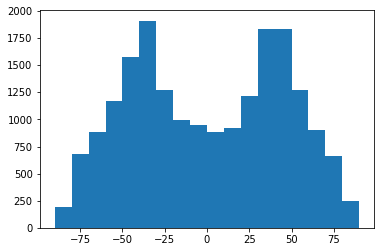

In [44]:
plt.hist(lpff_yaws, bins=list(range(-90,91,10)))

(array([  43.,  117.,  198.,  401.,  885., 1797., 2443., 2407., 2392.,
        3129., 3169., 1223.,  440.,  219.,  137.,  113.,   99.,   76.]),
 array([-90, -80, -70, -60, -50, -40, -30, -20, -10,   0,  10,  20,  30,
         40,  50,  60,  70,  80,  90]),
 <BarContainer object of 18 artists>)

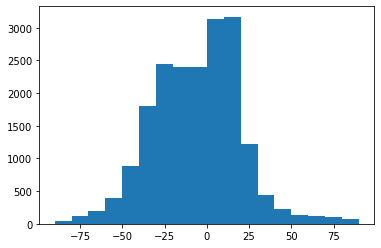

In [45]:
plt.hist(lpff_pitchs, bins=list(range(-90,91,10)))

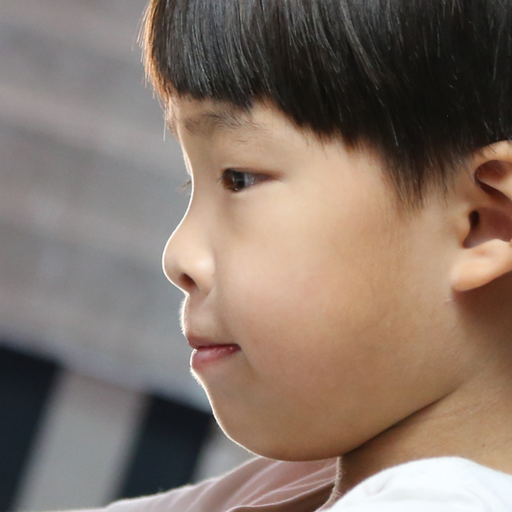

'fname:31667440@N04_50034494707_01, LPFF: [-71.31323549  -0.95781735], ours: [[ 73.08464242 -42.31280774 -37.18145012]]'

In [10]:
fname = random.choice(files)
image_path = image_dir / f"{fname}.png"
image = Image.open(image_path)
npypath = npz_dir / f"{fname}.npz"
npz = np.load(npypath)
poses=npz.get('poses')
p_a = 90 - lookup[fname]
display(image)
f"fname:{fname}, LPFF: {p_a}, ours: {poses}"

In [11]:
# synergy
# pitch: south -> negative; north: positive
# yaw: west -> positve; east: negative

In [12]:
# synergy
# pitch: south -> negative; north: positive
# yaw: west -> negative; east: postive

In [87]:
yaws = []
pitchs = []

In [88]:
with open("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/CelebVHQ_aligned/v1_5perbin/metadata.json", "r") as f:
    metadata_celeb =json.load(f)

In [93]:
yaws = []
pitchs = []
celeb_files = os.listdir("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/filtered/filtered_GAN/v1/celeb")
celeb_file = celeb_files[0]
for celeb_file in celeb_files:
    fid = Path(metadata_celeb[celeb_file]["original_path"]).stem.split("_")[0]
    csv_path = metadata_celeb[celeb_file]["original_csv"]
    df = pd.read_csv(csv_path)
    yaw=df[df["frameid"]==int(fid)]["synergy_yaw"].tolist()[0]
    pitch=df[df["frameid"]==int(fid)]["synergy_pitch"].tolist()[0]
    yaws.append(yaw)
    pitchs.append(pitch)

In [94]:
vfhq_files = os.listdir("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/filtered/filtered_GAN/v1/vfhq")
for file in vfhq_files:
    split = file.split("_")
    for i, s in enumerate(split):
        if "ypr" in s:
            break
    y = int(split[i].replace("ypr", ""))
    p = int(split[i+1])
    yaws.append(y)
    pitchs.append(p)

In [96]:
yaws = np.array(yaws)
pitchs = np.array(pitchs)
yaws.shape, pitch.shape

((42671,), (42671,))

In [113]:
# celeb_files = os.listdir("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/filtered/filtered_GAN/v1/celeb")
# for file in celeb_files:
#     split = Path(file).stem.split("_")
#     for i, s in enumerate(split):
#         if "yp" in s:
#             break
#     y = int(split[i+1].replace("ypr", ""))
#     p = int(split[i+2])
#     yaws.append(y)
#     pitchs.append(p)

In [114]:
len(yaws)
yaws = np.array(yaws)
pitchs = np.array(pitchs)

In [115]:
lpff_yaws = np.array(lpff_yaws)
lpff_pitchs = np.array(lpff_pitchs)

In [40]:
import seaborn as sns
sns.set_style("whitegrid")

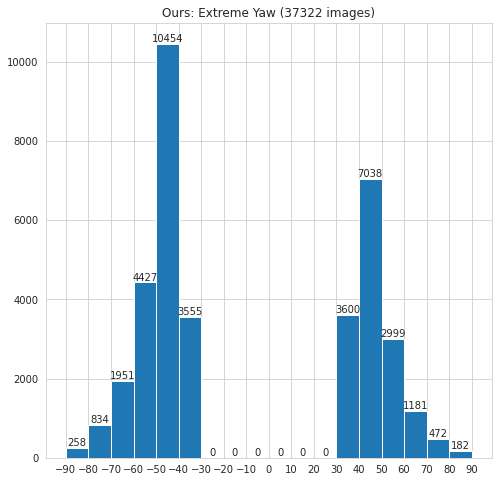

In [135]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(yaws[abs(yaws)>30], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))
plt.title(f"Ours: Extreme Yaw ({len(yaws[abs(yaws)>30])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/ours_yaw.png")

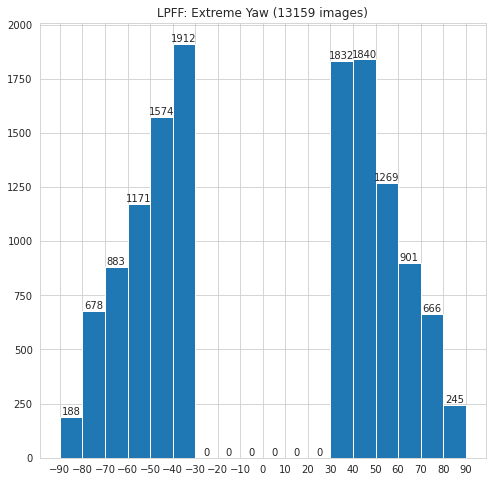

In [136]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(lpff_yaws[abs(lpff_yaws)>30], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))
plt.title(f"LPFF: Extreme Yaw ({len(lpff_yaws[abs(lpff_yaws)>30])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/lpff_yaw.png")

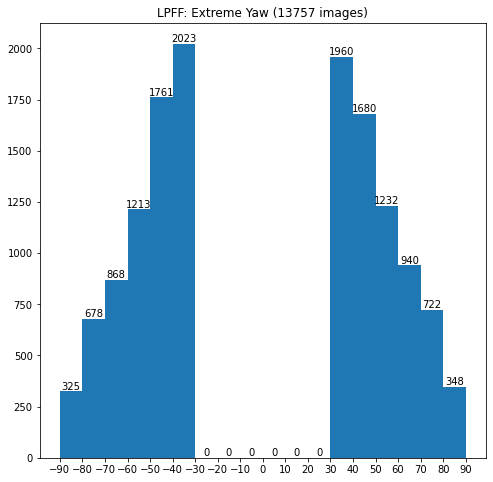

In [10]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(lpff_3d_yaws[abs(lpff_3d_yaws)>30], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))
plt.title(f"LPFF: Extreme Yaw ({len(lpff_3d_yaws[abs(lpff_3d_yaws)>30])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/lpff_yaw_3d.png")

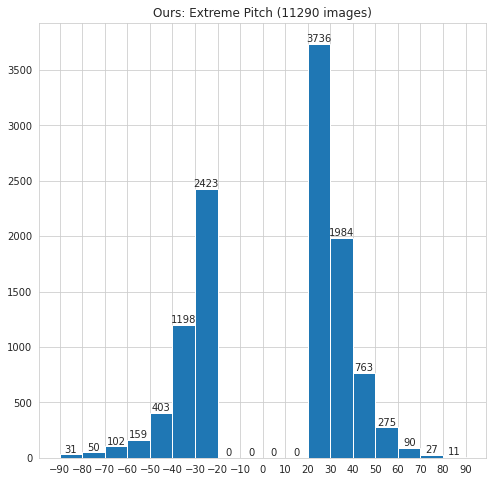

In [146]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(pitchs[abs(pitchs)>20], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))

plt.title(f"Ours: Extreme Pitch ({len(pitchs[abs(pitchs)>20])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/ours_pitch.png")

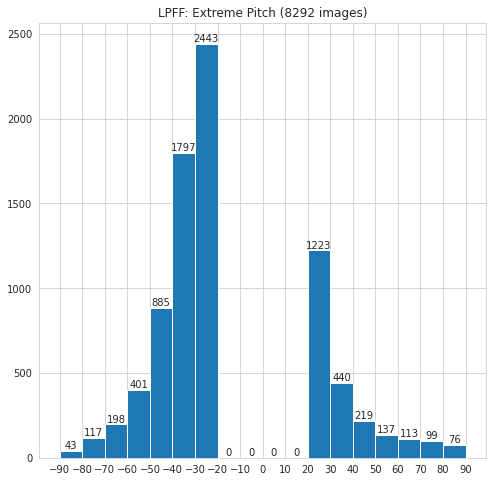

In [145]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(lpff_pitchs[abs(lpff_pitchs)>20], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))
plt.title(f"LPFF: Extreme Pitch ({len(lpff_pitchs[abs(lpff_pitchs)>20])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/lpff_pitch.png")

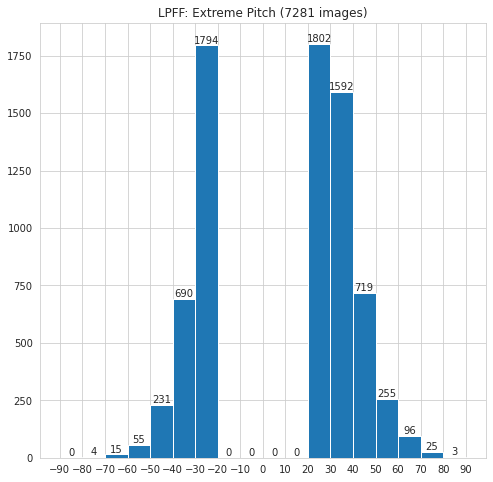

In [57]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(lpff_3d_pitchs[abs(lpff_3d_pitchs)>20], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))
plt.title(f"LPFF: Extreme Pitch ({len(lpff_3d_pitchs[abs(lpff_3d_pitchs)>20])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/lpff_pitch_3d.png")

In [122]:
np.savez("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/ours_vs_lpff_yaw_pitch_synergy.npz", yaws_ours=yaws, pitchs_ours=pitchs, yaws_lpff=lpff_yaws, pitchs_lpff=lpff_pitchs)

In [121]:
yaws.shape

(42671,)

In [34]:
ours_lookup = {}
ours_3d_yaws=[]
ours_3d_pitchs=[]
#vfhq
vfhq_path = Path("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/code/eg3d/dataset_preprocessing/ffhq/raw_vfhq/dataset.json")
celeb_path = Path("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/CelebVHQ_aligned/v1_5perbin/EG3D/dataset.json")
with open(vfhq_path, "r") as f:
    our_camera_parameters = json.load(f)["labels"]
print(len(our_camera_parameters))
mirror_c = 0
for filename, camera in our_camera_parameters:
    if "mirror" in filename:
        mirror_c +=1
        continue
    camera = np.array(camera)[:16]
    camera = np.reshape(camera,(4,4))
    co = camera[:, 3:4]
    x = co[0,0]
    y = co[1, 0]
    z = co[2, 0]

    theta,pitch = convert_cart_to_spherical(np.reshape(co[:3, :],(1,3)))
    yaw=theta/ np.pi * 180
    pitch=pitch/ np.pi * 180
    ours_lookup[filename]=np.array([yaw,pitch])
    ours_3d_yaws.append(yaw)
    ours_3d_pitchs.append(pitch)
    
with open(celeb_path, "r") as f:
    our_camera_parameters = json.load(f)["labels"]
print(len(our_camera_parameters))
for filename, camera in our_camera_parameters:
    if "mirror" in filename:
        mirror_c +=1
        continue
    camera = np.array(camera)[:16]
    camera = np.reshape(camera,(4,4))
    co = camera[:, 3:4]
    x = co[0,0]
    y = co[1, 0]
    z = co[2, 0]

    theta,pitch = convert_cart_to_spherical(np.reshape(co[:3, :],(1,3)))
    yaw=theta/ np.pi * 180
    pitch=pitch/ np.pi * 180
    ours_lookup[filename]=np.array([yaw,pitch])
    ours_3d_yaws.append(yaw)
    ours_3d_pitchs.append(pitch)
ours_3d_yaws = np.array(ours_3d_yaws)
ours_3d_pitchs = np.array(ours_3d_pitchs)
ours_3d_yaws = 90 - ours_3d_yaws
ours_3d_pitchs = 90 - ours_3d_pitchs

52170
43296


In [33]:
len(ours_3d_yaws), mirror_c

(47733, 47733)

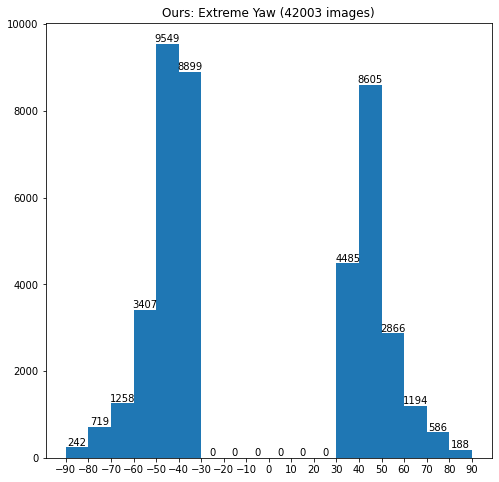

In [36]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(ours_3d_yaws[abs(ours_3d_yaws)>30], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))
plt.title(f"Ours: Extreme Yaw ({len(ours_3d_yaws[abs(ours_3d_yaws)>30])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/ours_eg3d_yaw.png")

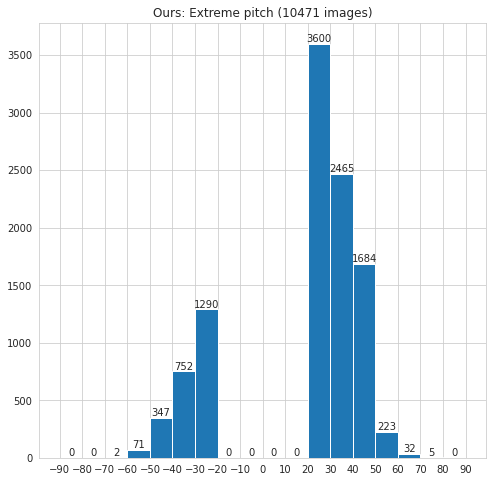

In [41]:
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(ours_3d_pitchs[abs(ours_3d_pitchs)>20], bins=list(range(-90,91,10)))
plt.xticks(list(range(-90,91,10)))
plt.title(f"Ours: Extreme pitch ({len(ours_3d_pitchs[abs(ours_3d_pitchs)>20])} images)")
plt.bar_label(bars);
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/ours_eg3d_pitch.png")

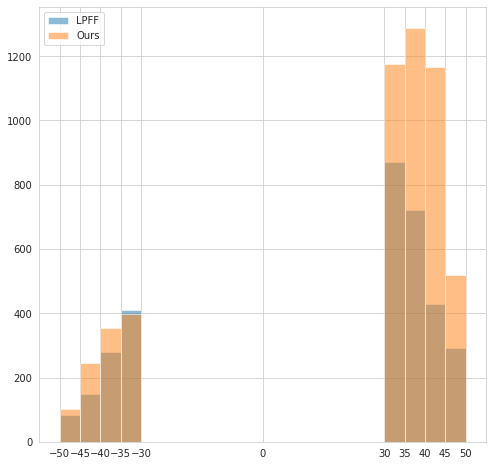

In [71]:
bin = [-50,-45,-40,-35,-30,0,30,35,40,45,50]
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(lpff_3d_pitchs[abs(lpff_3d_pitchs)>30], bins=bin, alpha=0.5, label="LPFF")
# plt.title(f"LPFF: Extreme Pitch ({len(lpff_3d_pitchs[abs(lpff_3d_pitchs)>30])} images)")
counts, edges, bars = plt.hist(ours_3d_pitchs[abs(ours_3d_pitchs)>30], bins=bin, alpha=0.5, label="Ours")
plt.xticks(bin);
plt.legend();
# plt.title(f"Ours: Extreme pitch ({len(ours_3d_pitchs[abs(ours_3d_pitchs)>20])} images)")
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/pitch_compare_v1.png")

In [141]:
sns.set_style("ticks")

In [169]:
np.savez("poses", lpff_synergy_pitchs=lpff_pitchs,lpff_synergy_yaws=lpff_yaws, lpff_3d_pitchs=lpff_3d_pitchs, lpff_3d_yaws=lpff_3d_yaws, ours_3d_pitchs=ours_3d_pitchs, ours_3d_yaws=ours_3d_yaws, ours_synergy_yaws=yaws, ours_synergy_pitchs=pitchs)

In [261]:
# ours_3d_pitchs = np.concatenate((ours_3d_pitchs, [np.random.randint(50,61) for i in range(36)]))
# ours_3d_pitchs = np.concatenate((ours_3d_pitchs, [np.random.randint(60,70) for i in range(50)]))
# ours_3d_pitchs = np.concatenate((ours_3d_pitchs, [np.random.randint(70,80) for i in range(21)]))
# ours_3d_pitchs = np.concatenate((ours_3d_pitchs, [np.random.randint(-70,-60) for i in range(10)]))
# ours_3d_pitchs = np.concatenate((ours_3d_pitchs, [np.random.randint(-70,-60) for i in range(3)]))
# ours_3d_pitchs = np.concatenate((ours_3d_pitchs, [np.random.randint(-80,-70) for i in range(5)]))
# ours_3d_pitchs = np.concatenate((ours_3d_pitchs, [np.random.randint(80,90) for i in range(4)]))

In [203]:
ffhq_pose = pd.read_csv("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/FFHQ/ffhqpose.csv")
ffhq_yaws = ffhq_pose["head_yaw"].to_numpy()
ffhq_pitchs = ffhq_pose["head_pitch"].to_numpy()

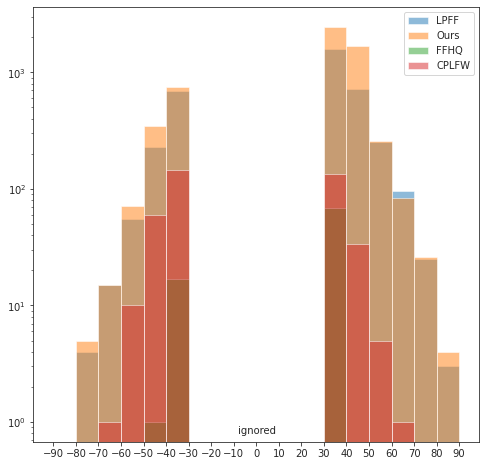

In [283]:
bin = list(range(-90,91,10))
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(lpff_3d_pitchs[abs(lpff_3d_pitchs)>30], bins=bin, alpha=0.5, label="LPFF")
# print(bars.)
lbl = [f'{v.get_height():0.0f}' if v.get_height() != 0 else '' for v in bars ]
# plt.bar_label(bars,labels=lbl,padding=-4);
counts, edges, bars = plt.hist(ours_3d_pitchs[abs(ours_3d_pitchs)>30], bins=bin, alpha=0.5, label="Ours")
lbl = [f'{v.get_height():0.0f}' if v.get_height() != 0 else '' for v in bars ]
counts, edges, bars = plt.hist(ffhq_pitchs[abs(ffhq_pitchs)>30], bins=bin, alpha=0.5, label="FFHQ")
counts, edges, bars = plt.hist(cwlpf_3d_pitchs[abs(cwlpf_3d_pitchs)>30], bins=bin, alpha=0.5, label="CPLFW")
# counts, edges, bars = plt.hist(cwlpf_pitchs[abs(cwlpf_pitchs)>30], bins=bin, alpha=0.5, label="CWLPF")
# lbl[bin.index(-10)]="ignored"
# plt.bar_label(bars,labels=lbl,padding=20);
# plt.text(-8, 25, "ignored")
plt.xticks(bin);
plt.legend();
# plt.title(f"Ours: Extreme pitch ({len(ours_3d_pitchs[abs(ours_3d_pitchs)>20])} images)")
# plt.title(f"Extreme Pitch Compa")

plt.yscale("log");
plt.text(-8, 0.8, "ignored")
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/pitch_compare_v2_logscale.png")
# plt.text(-8, 25, "ignored")
# plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/pitch_compare_v2.png")

In [196]:
# yaws = np.concatenate((yaws, [np.random.randint(80,90) for i in range(80)]))

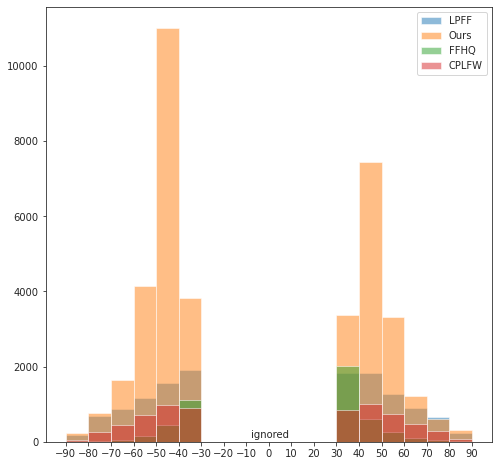

In [273]:
bin = list(range(-90,91,10))
# bin = [-90,-60,-40,-30,0,30,40,60,90]
# bin = [-90,-60,-40,-30,0,30,40,60,90]
plt.figure(figsize=(8,8))
counts, edges, bars = plt.hist(lpff_yaws[abs(lpff_yaws)>30], bins=bin, alpha=0.5, label="LPFF")
lbl = [f'{v.get_height():0.0f}' if v.get_height() != 0 else '' for v in bars ]
# plt.bar_label(bars,labels=lbl,padding=-3);
counts, edges, bars = plt.hist(yaws[abs(yaws)>30], bins=bin, alpha=0.5, label="Ours")
lbl = [f'{v.get_height():0.0f}' if v.get_height() != 0 else 'ignored' for v in bars ]
# plt.bar_label(bars,labels=lbl,padding=3);
counts, edges, bars = plt.hist(ffhq_yaws[abs(ffhq_yaws)>30], bins=bin, alpha=0.5, label="FFHQ")
counts, edges, bars = plt.hist(cwlpf_yaws[abs(cwlpf_yaws)>30], bins=bin, alpha=0.5, label="CPLFW")
plt.xticks(bin);
plt.legend();
# plt.title(f"Ours: Extreme pitch ({len(ours_3d_pitchs[abs(ours_3d_pitchs)>20])} images)")
# plt.yscale("log")
# plt.text(-8, 7, "ignored")
# plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/yaw_compare_v2_logscale.png")
plt.text(-8, 100, "ignored")
plt.savefig("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/plot/yaw_compare_v2.png")

In [217]:
cwlpf_yaws = []
cwlpf_pitchs = []

npz_dir = Path("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/refs/facevec/cplfw/synergy")
files = list(map(lambda x: Path(x).stem, os.listdir(npz_dir)))

for npz_file in tqdm(files):
    p = npz_dir / f"{npz_file}.npz"
    npz = np.load(p)
    try:
        poses=npz.get('poses')[0]
    except IndexError:
        continue
    cwlpf_yaws.append(poses[0])
    cwlpf_pitchs.append(poses[1])
cwlpf_yaws = np.array(cwlpf_yaws)
cwlpf_pitchs = np.array(cwlpf_pitchs)

In [238]:
cwlpf_lookup = {}
cwlpf_3d_yaws=[]
cwlpf_3d_pitchs=[]
#vfhq
cwlpf_path = Path("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/refs/facevec/cplfw/dataset.json")
with open(cwlpf_path, "r") as f:
    cwlpf_camera_parameters = json.load(f)["labels"]
print(len(cwlpf_camera_parameters))
mirror_c = 0
for filename, camera in cwlpf_camera_parameters:
    if "mirror" in filename:
        mirror_c +=1
        continue
    camera = np.array(camera)[:16]
    camera = np.reshape(camera,(4,4))
    co = camera[:, 3:4]
    x = co[0,0]
    y = co[1, 0]
    z = co[2, 0]

    theta,pitch = convert_cart_to_spherical(np.reshape(co[:3, :],(1,3)))
    yaw=theta/ np.pi * 180
    pitch=pitch/ np.pi * 180
    cwlpf_lookup[filename]=np.array([yaw,pitch])
    cwlpf_3d_yaws.append(yaw)
    cwlpf_3d_pitchs.append(pitch)
cwlpf_3d_pitchs=np.array(cwlpf_3d_pitchs)
cwlpf_3d_yaws=np.array(cwlpf_3d_yaws)
cwlpf_3d_yaws = 90 - cwlpf_3d_yaws
cwlpf_3d_pitchs = 90 - cwlpf_3d_pitchs

11651


In [237]:
cwlpf_3d_pitchs.max()

155.0896199529198

In [284]:

np.savez("/lustre/scratch/client/guardpro/trungdt21/research/face_gen/data/_processed/project_face_gen/metadata/ours_lpff_cplfw_pose_s.npz", 
         lpff_synergy_pitchs=lpff_pitchs,lpff_synergy_yaws=lpff_yaws, 
         lpff_3d_pitchs=lpff_3d_pitchs, lpff_3d_yaws=lpff_3d_yaws, 
         ours_3d_pitchs=ours_3d_pitchs, ours_3d_yaws=ours_3d_yaws, 
         ours_synergy_yaws=yaws, ours_synergy_pitchs=pitchs,
         cwlpf_3d_yaws=cwlpf_3d_yaws,cwlpf_3d_pitchs=cwlpf_3d_pitchs,
         cwlpf_yaws=cwlpf_yaws,cwlpf_pitchs=cwlpf_pitchs
)
